In [76]:
import numpy as np
import pandas as pd
from itertools import product
#from nltk import ngrams
#import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Calculate n grams

In [161]:
alphabet = 'абвгдеёжзийклмнопрстуфхцчьыъшщэюя'
n = 2

def build_n_grams(n):
    #combinations = dict()
    #for i in range(1,n+1):
    combinations = [''.join(val) for val in [p for p in product(list(alphabet),repeat = n)]]
    return combinations

n_grams = build_n_grams(n)

# Read textes and build dataframe

In [162]:
def build_dataframe(text: str, gramms):
    text_data = {}
    for i in gramms:
        text_data[i] = text.count(i)
    return text_data

In [163]:
def read_text(filepath, n_grams):
    data = {}
    with open(filepath, 'r') as f:
        try:
            text = ''.join(filter(str.isalpha, f.read()))
            data['lenght'] = len(text)
            data.update(build_dataframe(text, n_grams))
        except UnicodeDecodeError as e: 
            print('Unable to read the text (some encoding errors)')
            print('\033[91m {} \033[0m'.format(str(e)))
    return data

In [164]:
def read_authors(dirname, n_grams):
    data = []
    for _dir in os.listdir(dirname):
        _current_dir = os.path.join(dirname,_dir)
        if(os.path.isdir(_current_dir)):
            for _file in os.listdir(_current_dir):
                if '.DS_Store' in _file:
                    print('\033[91m {} \033[0m'.format(str('.DS_Store file')))
                else:
                    filepath = os.path.join(_current_dir, _file)
                    text = None
                    string_data = {'author': _dir, 'name': _file}
                    string_data.update(read_text(filepath, n_grams))
                    data.append(string_data)
    return data

# Read data for prediction 

In [165]:
def read_unknown(path, n_grams):
    data = {}
    for _file in os.listdir(path):
        if '.DS_Store' in _file:
            print('\033[91m {} \033[0m'.format(str('.DS_Store file')))
        else:
            data[_file] = [read_text(os.path.join(path, _file), n_grams)]
    return data

# Modify data and calculate PDF

In [167]:
data = read_authors('./50 000', n_grams)
df = pd.DataFrame(data)
unique_authors = df.author.unique()

 .DS_Store file 
 .DS_Store file 
 .DS_Store file 
 .DS_Store file 
 .DS_Store file 
 .DS_Store file 
 .DS_Store file 
 .DS_Store file 
 .DS_Store file 
 .DS_Store file 


In [168]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,author,lenght,name,аа,аб,ав,аг,ад,ае,аж,...,ёч,ёш,ёщ,ёъ,ёы,ёь,ёэ,ёю,ёя,ёё
0,Хаскли,44158,Хаксли О. Гений и богиня. часть 3,20,68,187,81,117,88,64,...,0,0,0,0,0,0,0,0,0,0
1,Калинина,41566,Калинина Н. Узор твоих снов часть 1,8,68,243,44,203,69,65,...,0,0,0,0,0,0,0,0,0,0
2,Агапкин,44267,Агапкин С. 1000 советов доктора Агапкина. часть 2,21,105,184,37,55,154,55,...,0,0,0,0,0,0,0,0,0,0
3,Достоевский,39502,Достоевский. Идиот,6,25,197,58,90,102,114,...,1,0,0,0,0,0,6,0,0,0
4,Марк Фрост,41165,Марк Фрост. Список семи часть 2,5,59,201,54,97,58,66,...,0,0,0,0,0,0,0,0,0,0


In [169]:
#Unique authors list
unique_authors

array(['Хаскли', 'Ильин', 'Калинина', 'Курпатов', 'Агапкин', 'Марк Фрост',
       'Достоевский', 'Тургенев', 'Генри Миллер', 'Александрова',
       'Казанцев'], dtype=object)

In [170]:
#Dense probabulity for all combinations
def dense_probability(text_frame):
    return text_frame.div(text_frame.lenght, axis=0)

def calc_ethalon(author, data_frame):
    _df = data_frame.loc[data_frame.author == author].drop(['author', 'name'], axis=1).sum()
    return dense_probability(_df)

In [171]:
#Calculate distance between text and the ethalon. We need only letters combinations to pass the function arguments
def dist_between_text_ethalon(text, ethalon):
    dist = np.sum(np.absolute(np.array(text - ethalon)))
    return dist
#Calculate the deviation of the own textes from pseudo ethalon. Own text is excluded form the ethalon
def deviation_own(author, data_frame):
    distances = []
    current_text = None
    ethalon_without_current = None
    data_frame = data_frame.loc[data_frame.author == author].drop(['author', 'name'], axis=1)
    for i in data_frame.index:
        current_text = dense_probability(data_frame.loc[[i]])
        ethalon_without_current = dense_probability(data_frame.drop([i], axis=0).sum())
        distances.append(dist_between_text_ethalon(current_text, ethalon_without_current))
    return distances
#Calculate the deviation of the foreign textes from ethalon
def deviation_foreign(author, ethalon, data_frame):
    distances = []
    current_text = None
    data_frame = data_frame.loc[data_frame.author != author].drop(['author', 'name'], axis=1)
    for i in data_frame.index:
        current_text = dense_probability(data_frame.loc[[i]])
        distances.append(dist_between_text_ethalon(current_text, ethalon))
    return distances

In [208]:
#Calculate author ethalon
authors_e = {}
authors_deviation = {}
for author in unique_authors:
    authors_e[author] = calc_ethalon(author, df)
    authors_deviation[author] = {'own' : min(deviation_own(author, df)), 'foreign' : max(deviation_foreign(author, authors_e[author], df))}

In [252]:
#author textes diviation from ethalon
authors_deviation

{'Хаскли': {'own': 0.11143442313592859, 'foreign': 0.38370391598146913},
 'Ильин': {'own': 0.14266735328293967, 'foreign': 0.4034276137144661},
 'Калинина': {'own': 0.11704816175569563, 'foreign': 0.4420284135128013},
 'Курпатов': {'own': 0.13531552838454333, 'foreign': 0.3849726464421892},
 'Агапкин': {'own': 0.18212890987222977, 'foreign': 0.41364619865104185},
 'Марк Фрост': {'own': 0.126432879587618, 'foreign': 0.4108224998944241},
 'Достоевский': {'own': 0.14112832849006085, 'foreign': 0.4375430542263786},
 'Тургенев': {'own': 0.1315130453737245, 'foreign': 0.4425852564874873},
 'Генри Миллер': {'own': 0.13065119741582587, 'foreign': 0.39364502892409164},
 'Александрова': {'own': 0.12008234571367085, 'foreign': 0.416214269564688},
 'Казанцев': {'own': 0.12746013384181387, 'foreign': 0.4057676418597427}}

In [210]:
ro_div = 1
argmin = 0
argmax = 10
for i in authors_deviation:
    if authors_deviation[i]['own'] > argmin:
        argmin = authors_deviation[i]['own']
    if authors_deviation[i]['foreign'] < argmax:
        argmax = authors_deviation[i]['foreign']
ro_div = (argmin+argmax)/2

In [211]:
#distance to divide authors
ro_div

0.28291641292684944

# Authors prediction

In [251]:
predict = read_unknown('./predict', n_grams)

 .DS_Store file 


In [212]:
def text_distances(text, ethalons):
    dist = 1
    data_dist = {}
    for author in ethalons:
        dist = dist_between_text_ethalon(authors_e[author],dense_probability(text))
        data_dist[author] = dist
    return data_dist
def predict_text(text, ethalons, max_dist_own = 1, min_dist_foreign = 1):
    distances = text_distances(text, ethalons)
    author_min = min(distances, key = lambda x: distances.get(x))
    author = author_min if distances[author_min] < ro_div else 'unknown'
    return author, distances[author_min]
        

In [213]:
predictions = {}
for i in predict:
    predictions[i] = predict_text(pd.DataFrame(predict[i]),authors_e)

In [253]:
#prediction for unknown authors
predictions

{'Александрова Н. Миллион черных роз': ('Александрова', 0.1461649652283948),
 'Слабое сердце - Достоевский': ('Достоевский', 0.22004908703313503),
 'Марк Фрост. Шесть Мессий часть 1 4.20.53 PM': ('Марк Фрост',
  0.13502469296351713),
 'Ползунков - Достоевский': ('Достоевский', 0.21543777771214737)}

# Graphics for the first method

In [248]:
def build_data_for_drawing(authors_deviation):
    average_distributions_own = []
    average_distributions_foreign = []
    for dev in authors_deviation:
        average_distributions_own.extend(deviation_own(dev, df))
        average_distributions_foreign.extend(deviation_foreign(dev,authors_e[dev], df))
    x_data_own = np.linspace(min(average_distributions_own), max(average_distributions_own), 10)
    y_data_own = np.zeros(10)
    for i in average_distributions_own:
        y_data_own[np.searchsorted(x_data_own, i)] += 1
    y_data_own = y_data_own/len(average_distributions_own)
    
    x_data_foreign = np.linspace(min(average_distributions_foreign), max(average_distributions_foreign), 10)
    y_data_foreign = np.zeros(10)
    for i in average_distributions_foreign:
        y_data_foreign[np.searchsorted(x_data_foreign, i)] += 1
    y_data_foreign = y_data_foreign/len(average_distributions_foreign)
    
    plt.plot(x_data_own, y_data_own, label="own text")
    plt.plot(x_data_foreign, y_data_foreign, label="foreign text")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    return True

True

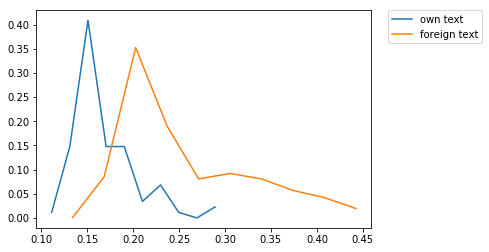

In [250]:
build_data_for_drawing(authors_deviation)